In [40]:
import os  # Dosya ve klasör işlemleri (oluşturma, kontrol, vs.) için kullanılır.
import pandas as pd  # Veri okuma, işleme ve analiz için kullanılan güçlü bir kütüphane.
import matplotlib.pyplot as plt  # Grafik ve görselleştirme için kullanılır.
import seaborn as sns  # Daha şık ve gelişmiş istatistiksel grafikler çizmek için matplotlib'e yardımcı kütüphane.
from sklearn.ensemble import RandomForestClassifier  # Makine öğrenmesi için Random Forest sınıflandırma modeli.
from sklearn.model_selection import train_test_split  # Veriyi eğitim ve test olarak ikiye ayırmak için kullanılır.
from sklearn.metrics import classification_report, confusion_matrix  # Model performansını değerlendirme araçları (doğruluk, F1 skoru, vb.).
import numpy as np  # Sayısal hesaplamalar ve dizi işlemleri için temel bilimsel hesaplama kütüphanesi.

In [41]:
# Klasörleri oluştur
if not os.path.exists('images'):
    os.makedirs('images')
if not os.path.exists('processed'):
    os.makedirs('processed')

In [42]:
# --- 1. Veri Yükleme ve Ön İşleme ---
Data = pd.read_csv("/content/Data.csv")
Data['tarih'] = pd.to_datetime(Data['tarih'])
Data['ay'] = Data['tarih'].dt.to_period('M')
Data['gun'] = Data['tarih'].dt.day
Data['yil'] = Data['tarih'].dt.year
Data['saat'] = pd.to_datetime(Data['saat'], format='%H:%M:%S').dt.hour

def zaman_dilim(hour):
    return 'Gunduz' if 6 <= hour < 18 else 'Gece'

Data['zaman_dilimi'] = Data['saat'].apply(zaman_dilim)

In [43]:
# --- 2. Temel İstatistikler ve Görselleştirmeler ---
print("\n-- Temel İstatistikler --")
print(Data.describe(include='all'))
print("\n-- En çok kullanılan cihazlar --")
print(Data['cihaz_modeli'].value_counts(normalize=True).head(10))
print("\n-- En çok çekim yapılan konumlar --")
print(Data['konum'].value_counts(normalize=True).head(10))

sns.set(style="whitegrid")


-- Temel İstatistikler --
        fotograf_id                       tarih         saat  \
count   1500.000000                        1500  1500.000000   
unique          NaN                         NaN          NaN   
top             NaN                         NaN          NaN   
freq            NaN                         NaN          NaN   
mean     750.500000  2024-03-23 23:43:40.800000    11.268000   
min        1.000000         2023-01-01 00:00:00     0.000000   
25%      375.750000         2023-07-31 12:00:00     5.000000   
50%      750.500000         2024-03-28 00:00:00    11.000000   
75%     1125.250000         2024-11-14 06:00:00    17.000000   
max     1500.000000         2025-06-20 00:00:00    23.000000   
std      433.157015                         NaN     7.044236   

              cihaz_modeli        dosya_adi  konum       ay          gun  \
count                 1500             1500   1500     1500  1500.000000   
unique                  11             1500     12  

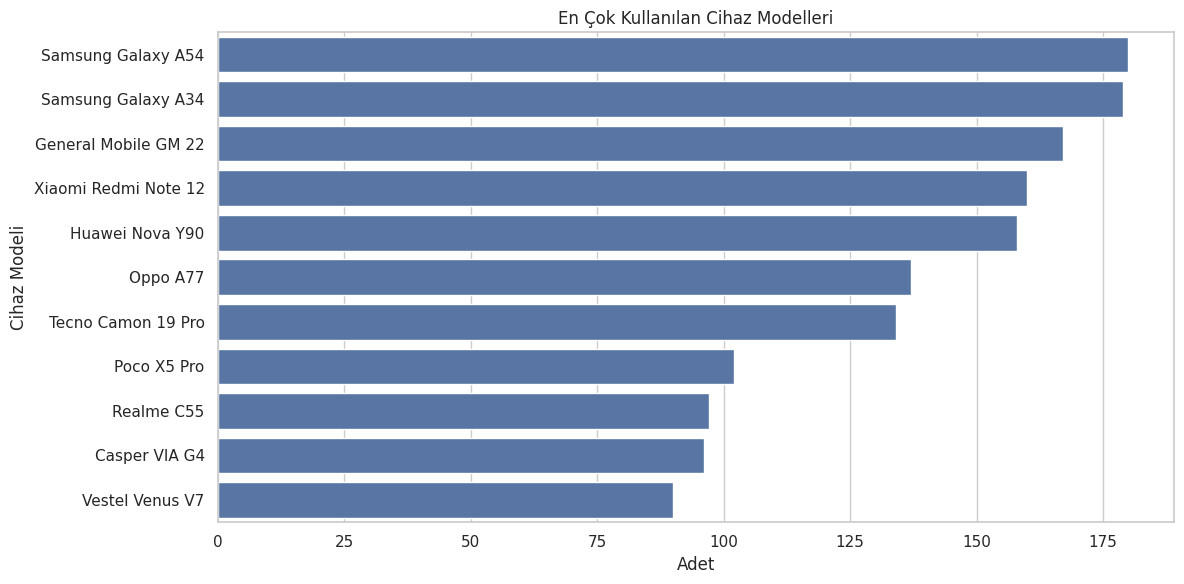

In [44]:
# 2.1 Cihaz Modeli Dağılımı
plt.figure(figsize=(12,6))
sns.countplot(y='cihaz_modeli', data=Data, order=Data['cihaz_modeli'].value_counts().index)
plt.title("En Çok Kullanılan Cihaz Modelleri")
plt.xlabel("Adet")
plt.ylabel("Cihaz Modeli")
plt.tight_layout()
plt.savefig("images/cihaz_modeli_grafik.png")
plt.show()

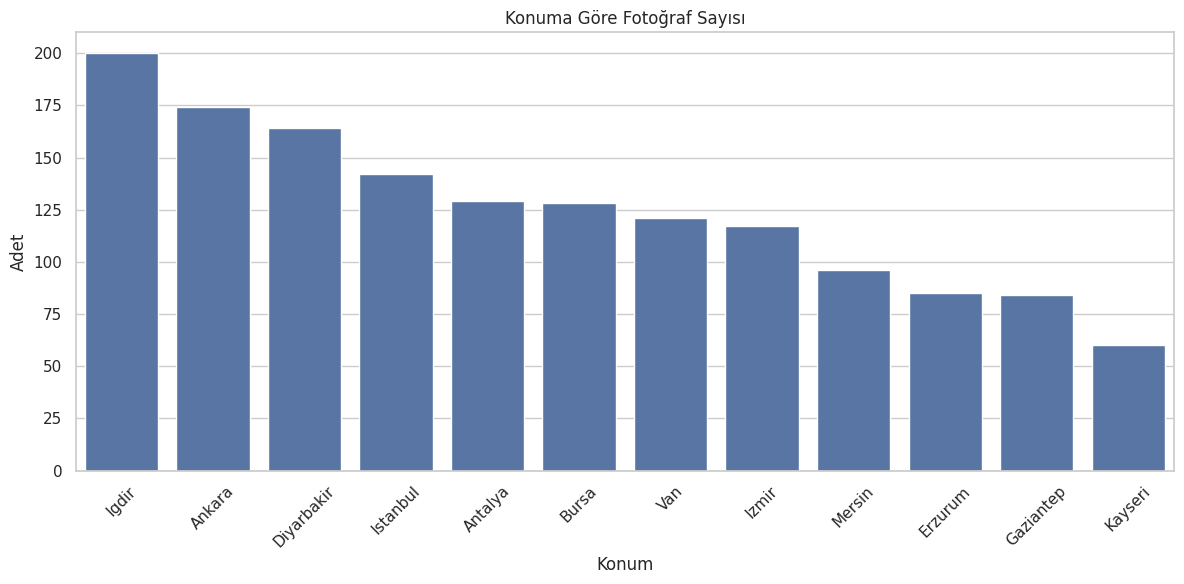

In [45]:
# 2.2 Konum Dağılımı
plt.figure(figsize=(12,6))
sns.countplot(x='konum', data=Data, order=Data['konum'].value_counts().index)
plt.title("Konuma Göre Fotoğraf Sayısı")
plt.xlabel("Konum")
plt.ylabel("Adet")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("images/konum_grafik.png")
plt.show()

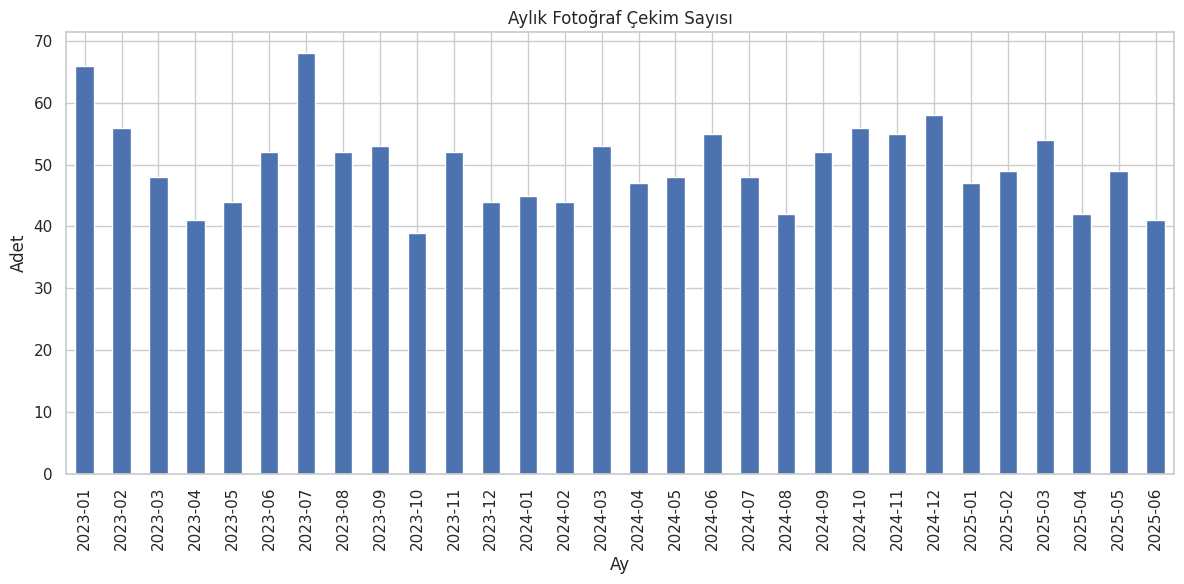

In [46]:
# 2.3 Aylık Çekim Sayısı
plt.figure(figsize=(12,6))
Data['ay'].value_counts().sort_index().plot(kind='bar')
plt.title("Aylık Fotoğraf Çekim Sayısı")
plt.xlabel("Ay")
plt.ylabel("Adet")
plt.tight_layout()
plt.savefig("images/aylik_grafik.png")
plt.show()

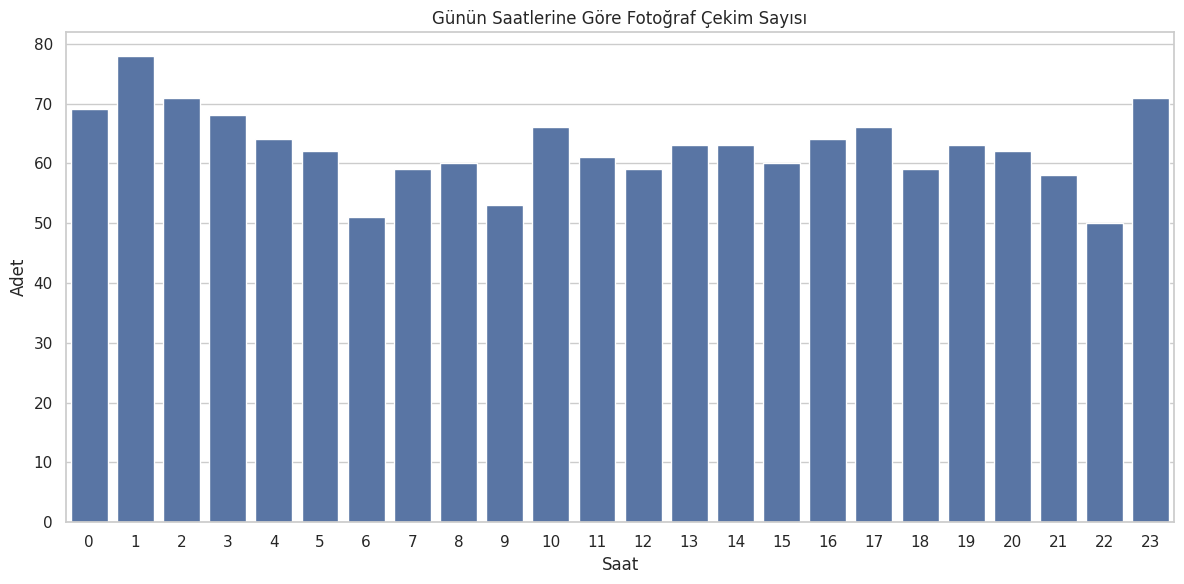

In [47]:
# 2.4 Saat Bazlı Çekim Yoğunluğu
plt.figure(figsize=(12,6))
sns.countplot(x='saat', data=Data)
plt.title("Günün Saatlerine Göre Fotoğraf Çekim Sayısı")
plt.xlabel("Saat")
plt.ylabel("Adet")
plt.tight_layout()
plt.savefig("images/saat_grafik.png")
plt.show()

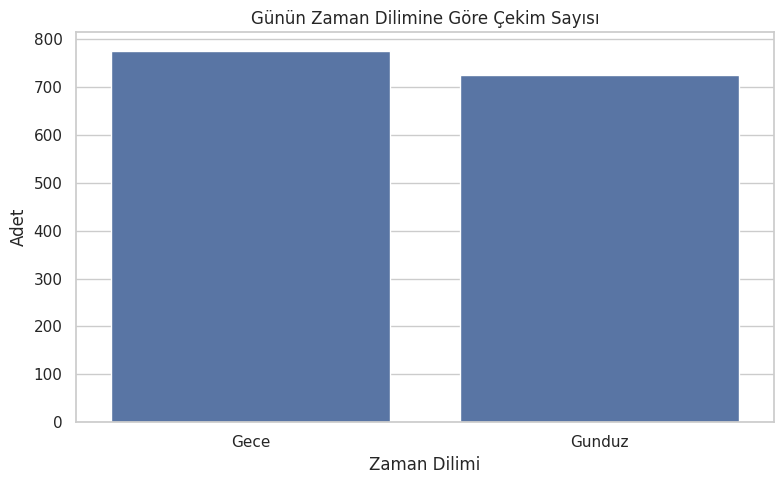

In [48]:
# 2.5 Zaman Dilimi Dağılımı
plt.figure(figsize=(8,5))
sns.countplot(x='zaman_dilimi', data=Data)
plt.title("Günün Zaman Dilimine Göre Çekim Sayısı")
plt.xlabel("Zaman Dilimi")
plt.ylabel("Adet")
plt.tight_layout()
plt.savefig("images/zaman_dilimi_grafik.png")
plt.show()

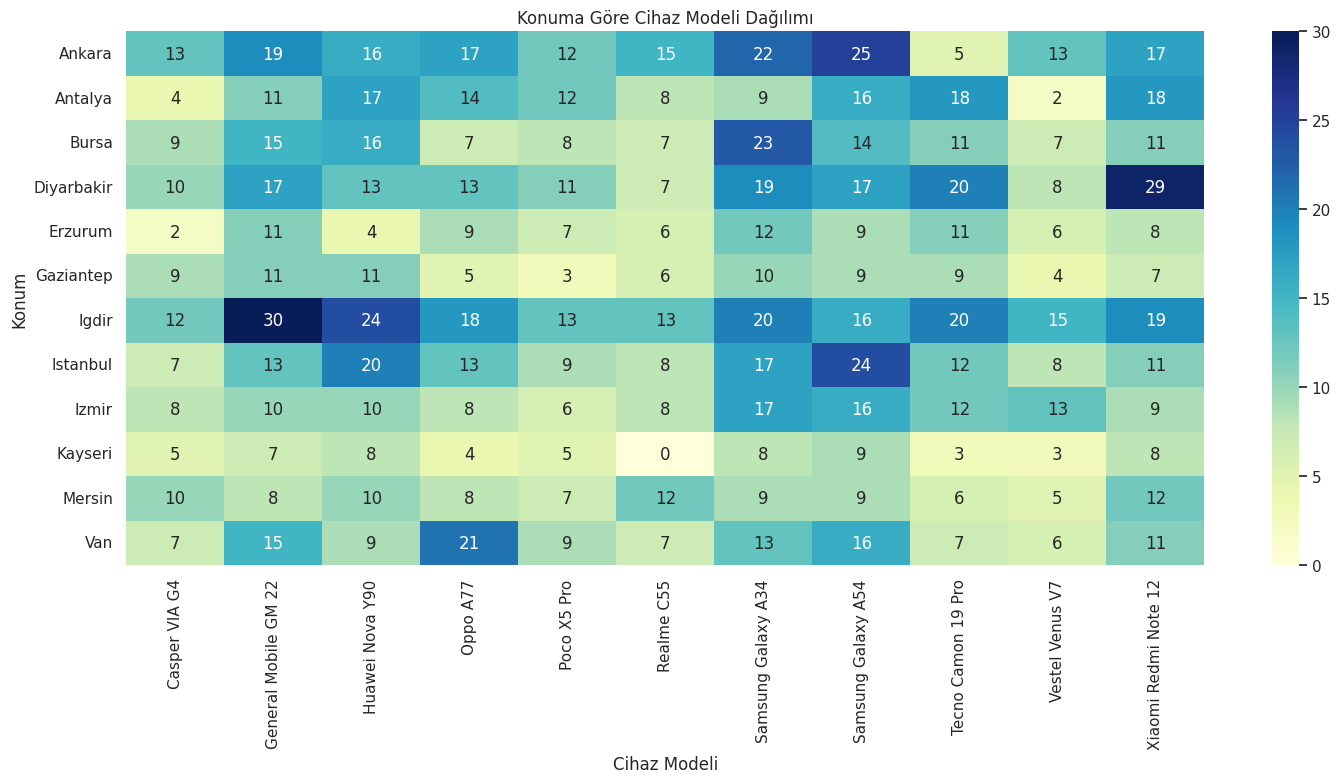

In [49]:
# 2.6 Konum-Cihaz Modeli Isı Haritası
pivot_table = pd.crosstab(Data['konum'], Data['cihaz_modeli'])
plt.figure(figsize=(15,8))
sns.heatmap(pivot_table, annot=True, fmt="d", cmap='YlGnBu')
plt.title("Konuma Göre Cihaz Modeli Dağılımı")
plt.xlabel("Cihaz Modeli")
plt.ylabel("Konum")
plt.tight_layout()
plt.savefig("images/konum_cihaz_heatmap.png")
plt.show()

In [50]:
# --- 3. Makine Öğrenmesi: Random Forest ile Cihaz Modeli Tahmini ---
Data_ml = Data.copy()
Data_ml['konum_kod'] = Data_ml['konum'].astype('category').cat.codes
Data_ml['cihaz_kod'] = Data_ml['cihaz_modeli'].astype('category').cat.codes

X = Data_ml[['saat', 'konum_kod']]
y = Data_ml['cihaz_kod']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [51]:
# Rapor
print("\n-- Makine Öğrenmesi Değerlendirmesi --")
rapor = classification_report(y_test, y_pred, target_names=Data_ml['cihaz_modeli'].astype('category').cat.categories)
print(rapor)


-- Makine Öğrenmesi Değerlendirmesi --
                      precision    recall  f1-score   support

       Casper VIA G4       0.10      0.06      0.07        17
General Mobile GM 22       0.10      0.10      0.10        39
     Huawei Nova Y90       0.03      0.04      0.03        26
            Oppo A77       0.16      0.15      0.15        27
         Poco X5 Pro       0.00      0.00      0.00        18
          Realme C55       0.00      0.00      0.00        22
  Samsung Galaxy A34       0.10      0.08      0.09        37
  Samsung Galaxy A54       0.09      0.15      0.11        33
  Tecno Camon 19 Pro       0.12      0.10      0.11        29
     Vestel Venus V7       0.06      0.06      0.06        16
Xiaomi Redmi Note 12       0.24      0.19      0.22        36

            accuracy                           0.10       300
           macro avg       0.09      0.09      0.09       300
        weighted avg       0.10      0.10      0.10       300



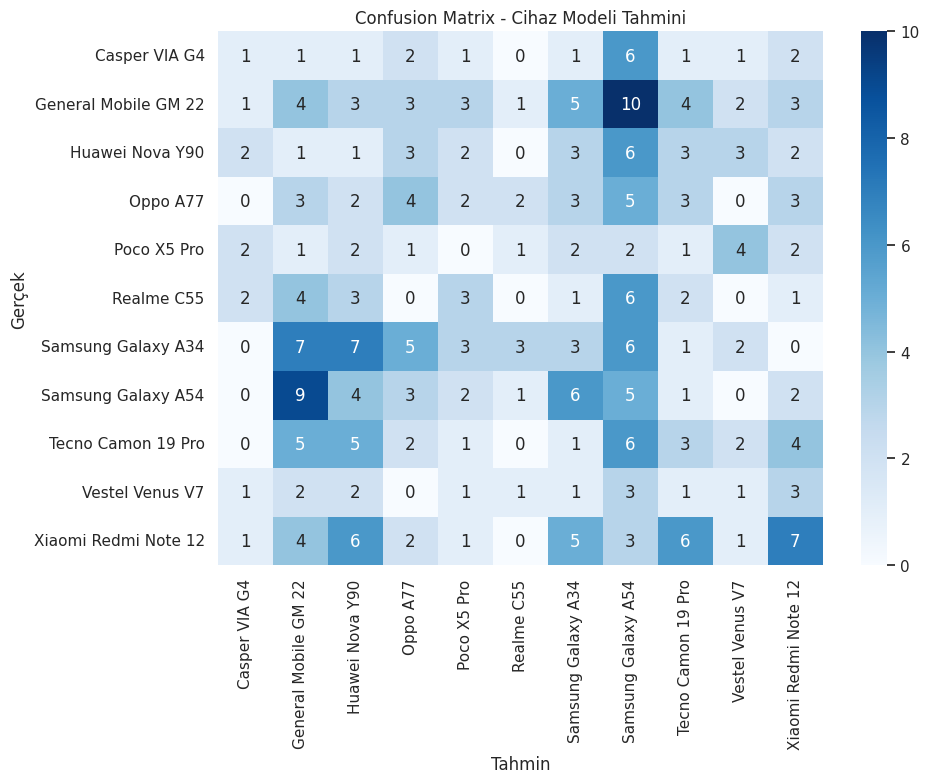

In [52]:
# Confusion Matrix görseli
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=Data_ml['cihaz_modeli'].astype('category').cat.categories,
            yticklabels=Data_ml['cihaz_modeli'].astype('category').cat.categories)
plt.xlabel('Tahmin')
plt.ylabel('Gerçek')
plt.title('Confusion Matrix - Cihaz Modeli Tahmini')
plt.tight_layout()
plt.savefig("images/confusion_matrix.png")
plt.show()

In [53]:
# --- 4. Çıktıların processed klasörüne kaydedilmesi ---
# 4.1 model_output.csv
output_df = pd.DataFrame({'Gerçek': y_test, 'Tahmin': y_pred})
output_df.to_csv('processed/model_output.csv', index=False)

In [54]:
# 4.2 classification_report.txt
with open("processed/classification_report.txt", "w") as f:
    f.write(rapor)

In [55]:
# 4.3 confusion_matrix.npy
np.save("processed/confusion_matrix.npy", cm)

In [56]:
# 4.4 konum_kodlama.csv
konum_mapping = dict(enumerate(Data_ml['konum'].astype('category').cat.categories))
pd.DataFrame(konum_mapping.items(), columns=['Kod', 'Konum']).to_csv('processed/konum_kodlama.csv', index=False)

In [57]:
# 4.5 cihaz_kodlama.csv
cihaz_mapping = dict(enumerate(Data_ml['cihaz_modeli'].astype('category').cat.categories))
pd.DataFrame(cihaz_mapping.items(), columns=['Kod', 'Cihaz Modeli']).to_csv('processed/cihaz_kodlama.csv', index=False)

In [58]:
# 4.6 veri_analiz_notlari.md
with open("processed/veri_analiz_notlari.md", "w", encoding='utf-8') as f:
    f.write("""\
# Veri Analiz Notları

- Toplam {} fotoğraf kaydı incelendi.
- {} farklı cihaz modeli tespit edildi.
- {} farklı konumdan çekim yapıldı.
- Fotoğrafların çoğu {} ile {} saatleri arasında çekilmiş.
- Cihaz modeline göre tahmin doğruluğu: {:.2f}%.

""".format(
    len(Data),
    Data['cihaz_modeli'].nunique(),
    Data['konum'].nunique(),
    Data['saat'].min(), Data['saat'].max(),
    (y_pred == y_test).sum() / len(y_test) * 100
))